## RANDOM FOREST

In [14]:
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
FEATURES_CSV = "/Users/evan/Documents/Projects/TikTok-TechJam-2025/feature_engineering_model/temp.csv"
LABELS_CSV = "/Users/evan/Documents/Projects/TikTok-TechJam-2025/data_gpt_labeler/final_data_labeled_1.csv"
TEXT_COL = "text"
TARGET_COL = "policy_label"
FEATURE_COLS = ["A","B","D2","E","G"]

In [3]:

# Load files
df_feat  = pd.read_csv(FEATURES_CSV)
df_label = pd.read_csv(LABELS_CSV)

In [5]:
# Merge by index order
df = pd.concat(
    [df_feat.reset_index(drop=True), 
     df_label[[TARGET_COL, TEXT_COL]].reset_index(drop=True)], 
    axis=1
)

print("Merged dataset:", df.shape)
df.head()

Merged dataset: (10000, 7)


,A,B,D2,E,G,policy_label,text
0,0.126823,0.581653,0.660104,0.993421,0.999407,1,My husband took me here for my birthday! The ...
1,0.066522,0.565305,0.620909,0.360918,0.997275,1,was a great place. Now closed. Too bad. We'll...
2,0.158263,0.575038,0.551840,0.987322,0.999049,1,"cozy, great food. love how you can sign your b..."
3,0.062633,0.575837,0.630236,0.859828,0.999422,1,"Not your average little Italian joint, don't e..."
4,0.005904,0.572793,0.792418,0.901759,0.999557,1,Service was great and the mozzarella fritta an...


In [6]:
X = df[FEATURE_COLS].values
y = df[TARGET_COL].values

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Class balance:", dict(zip(*np.unique(y, return_counts=True))))


X shape: (10000, 5)
y shape: (10000,)
Class balance: {np.int64(0): np.int64(1090), np.int64(1): np.int64(8910)}


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y if len(np.unique(y)) == 2 else None
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (8000, 5) Test size: (2000, 5)


In [8]:
rf_clf = RandomForestClassifier(
    n_estimators=200,           # number of trees
    max_depth=None,             # let it grow fully
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"     # <-- important for imbalance
)

rf_clf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [9]:
y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Accuracy: 0.891

Classification Report:
              precision    recall  f1-score   support

           0     0.5000    0.1468    0.2270       218
           1     0.9039    0.9820    0.9414      1782

    accuracy                         0.8910      2000
   macro avg     0.7020    0.5644    0.5842      2000
weighted avg     0.8599    0.8910    0.8635      2000


Confusion Matrix:
 [[  32  186]
 [  32 1750]]


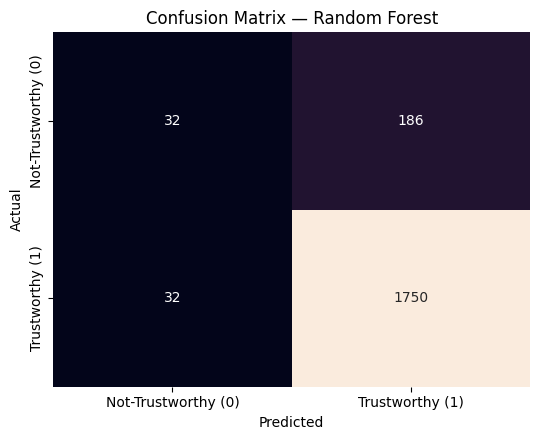

In [10]:
plt.figure(figsize=(5.5, 4.5))
sns.heatmap(
    cm, annot=True, fmt="d", cbar=False,
    xticklabels=["Not-Trustworthy (0)", "Trustworthy (1)"],
    yticklabels=["Not-Trustworthy (0)", "Trustworthy (1)"]
)
plt.title("Confusion Matrix — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [13]:
df = pd.read_csv("/Users/evan/Documents/Projects/TikTok-TechJam-2025/data_gpt_labeler/final_data_labeled_3.csv")
length = len(df[df['policy_label'].isna()])
print(f"Number of NaN values: {length}")


Number of NaN values: 4771
